This notebook is a **deep diagnostic companion** to Part 3.

## Goals
We will build, inspect, and compare three implementations:

1) **Manual modules** (our own `Linear`, `BatchNorm1d`, `Tanh`)
2) **A compact “model graph”** that chains modules like PyTorch `nn.Sequential`
3) **PyTorch reference** (`torch.nn.Linear`, `torch.nn.BatchNorm1d`) to validate behavior

## What we will cover (mirrors Karpathy Part 3)
- Why deep nets are hard: activation saturation, vanishing gradients, “dead” units (ReLU discussion)
- BatchNorm math: per-batch mean/variance, $\epsilon$, **affine** $(\gamma,\beta)$, **momentum**, running stats
- Train vs eval behavior (critical!)
- Initialization sensitivity and what modern practice does
- Diagnostics:
  - activation distributions / histograms
  - % saturated tanh units
  - gradient distributions / norms
  - weight distributions
- Sampling with **temperature** and its effect
- Why results differ from Karpathy’s (hyperparams, seeds, minor architectural differences)
- Coupling issue in BatchNorm and alternatives (LayerNorm/GroupNorm/RMSNorm conceptually)

In [1]:
# imports, device, reproducibility, and repo path

from __future__ import annotations

import math
from dataclasses import dataclass
from pathlib import Path

import torch
import torch.nn.functional as F

# reproducibility
SEED = 1337
torch.manual_seed(SEED)

# device (MPS on Mac if available)
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print("device:", device)

# repo root resolution (consistent with your earlier notebooks)
REPO_ROOT = Path.cwd()
if not (REPO_ROOT / "data").exists() and (REPO_ROOT.parent / "data").exists():
    REPO_ROOT = REPO_ROOT.parent

data_path = REPO_ROOT / "data" / "names.txt"
print("repo root:", REPO_ROOT)
print("data path:", data_path)
print("data exists:", data_path.exists())

device: mps
repo root: /Users/home/Developer/github/makemore-notes
data path: /Users/home/Developer/github/makemore-notes/data/names.txt
data exists: True


In [2]:
# load data, build vocabulary, and splits (train/dev/test)

# load words
words = data_path.read_text(encoding="utf-8").splitlines()
print("num words:", len(words))
print("sample words:", words[:5])

# vocabulary ('.' = 0)
chars = sorted(set("".join(words)))
stoi = {ch: i + 1 for i, ch in enumerate(chars)}
stoi["."] = 0
itos = {i: ch for ch, i in stoi.items()}
vocab_size = len(itos)

print("vocab size:", vocab_size)
print("itos (first 10):", list(itos.items())[:10])

# reproducible shuffle + split
g_cpu = torch.Generator().manual_seed(SEED)
perm = torch.randperm(len(words), generator=g_cpu).tolist()
words_shuf = [words[i] for i in perm]

n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))
words_tr = words_shuf[:n1]
words_dev = words_shuf[n1:n2]
words_te = words_shuf[n2:]

print("splits:", len(words_tr), len(words_dev), len(words_te))
print("train sample:", words_tr[:5])

num words: 32033
sample words: ['emma', 'olivia', 'ava', 'isabella', 'sophia']
vocab size: 27
itos (first 10): [(1, 'a'), (2, 'b'), (3, 'c'), (4, 'd'), (5, 'e'), (6, 'f'), (7, 'g'), (8, 'h'), (9, 'i'), (10, 'j')]
splits: 25626 3203 3204
train sample: ['christie', 'edi', 'wallace', 'arieliz', 'aboubacar']


In [3]:
# dataset builder (context windows) + sanity check

block_size = 3  # context length (we will vary this later)

def build_dataset(words_list: list[str], block_size: int):
    X, Y = [], []
    for w in words_list:
        context = [0] * block_size
        for ch in w + ".":
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]
    X = torch.tensor(X, dtype=torch.long, device=device)
    Y = torch.tensor(Y, dtype=torch.long, device=device)
    return X, Y

Xtr, Ytr = build_dataset(words_tr, block_size)
Xdev, Ydev = build_dataset(words_dev, block_size)
Xte, Yte = build_dataset(words_te, block_size)

print("Xtr/Ytr:", Xtr.shape, Ytr.shape)
print("Xdev/Ydev:", Xdev.shape, Ydev.shape)
print("Xte/Yte:", Xte.shape, Yte.shape)

def decode_ctx(ctx):
    return "".join(itos[int(i)] for i in ctx)

for i in range(5):
    print(f"{i:>3}  X='{decode_ctx(Xtr[i])}' -> Y='{itos[int(Ytr[i])]}'")

Xtr/Ytr: torch.Size([182508, 3]) torch.Size([182508])
Xdev/Ydev: torch.Size([22860, 3]) torch.Size([22860])
Xte/Yte: torch.Size([22778, 3]) torch.Size([22778])
  0  X='...' -> Y='c'
  1  X='..c' -> Y='h'
  2  X='.ch' -> Y='r'
  3  X='chr' -> Y='i'
  4  X='hri' -> Y='s'


## Diagnostic mindset: what we will measure and why

In Part 3, the key lesson is not “BatchNorm exists” — it’s **how to tell when a network is healthy**.

During training, we will track:

### 1) Loss (obvious)
- Train loss and dev loss

### 2) Activation distributions
- Are activations centered?
- Are they saturated (for `tanh`)?
- Do they drift over time?

### 3) Gradient distributions
- Are gradients tiny (vanishing) or huge (exploding)?
- Do some layers get no signal?

### 4) Weight distributions
- Are weights growing uncontrollably?
- Are they stuck near zero?

### 5) BatchNorm specific diagnostics
- Running mean/variance behavior (train vs eval)
- Coupling: behavior depends on batch composition and batch size

We’ll implement utility functions to compute and plot:
- histograms for activations/gradients/weights
- saturation rate for `tanh`
- gradient norms per parameter

Next cell: setup plotting + diagnostic helpers.

In [ ]:
# plotting + diagnostic helpers (histograms, saturation, grad norms)

import matplotlib.pyplot as plt

def tensor_stats(x: torch.Tensor):
    """Return basic stats for a tensor (safe for empty tensors)."""
    x = x.detach().flatten()
    if x.numel() == 0:
        return {"n": 0}
    return {
        "n": x.numel(),
        "mean": x.mean().item(),
        "std": x.std(unbiased=False).item(),
        "min": x.min().item(),
        "max": x.max().item(),
    }

def plot_hist(x: torch.Tensor, title: str, bins: int = 100):
    """Simple histogram plot (no seaborn)."""
    x = x.detach().flatten().float().cpu()
    plt.figure()
    plt.hist(x.numpy(), bins=bins)
    plt.title(title)
    plt.show()

def tanh_saturation_rate(h: torch.Tensor, threshold: float = 0.97) -> float:
    """
    For tanh activations h in (-1, 1):
    counts fraction where |h| > threshold (near saturation).
    """
    h = h.detach()
    return (h.abs() > threshold).float().mean().item()

def grad_norm(p: torch.Tensor) -> float:
    """L2 norm of gradient for parameter p (0 if grad is None)."""
    if p.grad is None:
        return 0.0
    return p.grad.detach().norm().item()

print("helpers ready")

helpers ready


In [5]:
# minimal module system (Karpathy-style, PyTorch-inspired)

class Module:
    """Base class: defines the interface used by all modules."""
    def parameters(self):
        return []

    def train(self):
        pass

    def eval(self):
        pass


class Linear(Module):
    """
    Linear layer: y = xW + b

    This mirrors torch.nn.Linear but implemented explicitly so we can:
    - control initialization
    - inspect weights/gradients
    - understand fan-in scaling
    """
    def __init__(self, fan_in: int, fan_out: int, *, bias: bool = True, generator=None):
        # Kaiming/Xavier-style scaling (tanh-friendly)
        self.W = torch.randn((fan_in, fan_out), generator=generator, device=device) / math.sqrt(fan_in)
        self.b = torch.zeros((fan_out,), device=device) if bias else None

    def __call__(self, x: torch.Tensor) -> torch.Tensor:
        y = x @ self.W
        if self.b is not None:
            y = y + self.b
        return y

    def parameters(self):
        return [self.W] + ([] if self.b is None else [self.b])


class Tanh(Module):
    """Pure activation layer."""
    def __call__(self, x: torch.Tensor) -> torch.Tensor:
        return torch.tanh(x)


class BatchNorm1d(Module):
    """
    BatchNorm1d implemented from scratch.

    Key concepts:
    - per-batch mean/var during training
    - running mean/var for inference
    - affine parameters (gamma, beta)
    """
    def __init__(self, dim: int, eps: float = 1e-5, momentum: float = 0.1):
        self.eps = eps
        self.momentum = momentum

        # affine parameters
        self.gamma = torch.ones((dim,), device=device)
        self.beta = torch.zeros((dim,), device=device)

        # running statistics (buffers)
        self.running_mean = torch.zeros((dim,), device=device)
        self.running_var = torch.ones((dim,), device=device)

        self.training = True

    def __call__(self, x: torch.Tensor) -> torch.Tensor:
        if self.training:
            mean = x.mean(dim=0)
            var = x.var(dim=0, unbiased=False)

            x_hat = (x - mean) / torch.sqrt(var + self.eps)

            # update running stats (no grad)
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * mean
                self.running_var  = (1 - self.momentum) * self.running_var  + self.momentum * var
        else:
            x_hat = (x - self.running_mean) / torch.sqrt(self.running_var + self.eps)

        return self.gamma * x_hat + self.beta

    def train(self):
        self.training = True

    def eval(self):
        self.training = False

    def parameters(self):
        return [self.gamma, self.beta]


print("custom modules defined")

custom modules defined


In [6]:
# embedding table + Sequential container + model assembly (deep MLP + BN)

class Embedding(Module):
    """
    Embedding table: maps token indices -> vectors.
    Equivalent to one-hot + Linear, but implemented as lookup.
    """
    def __init__(self, num_embeddings: int, embedding_dim: int, *, generator=None):
        self.weight = torch.randn((num_embeddings, embedding_dim), generator=generator, device=device)

    def __call__(self, x: torch.Tensor) -> torch.Tensor:
        # x: (...,) long indices
        return self.weight[x]

    def parameters(self):
        return [self.weight]


class Flatten(Module):
    """Flatten last two dims: (B, T, C) -> (B, T*C)"""
    def __call__(self, x: torch.Tensor) -> torch.Tensor:
        return x.view(x.shape[0], -1)


class Sequential(Module):
    """A tiny version of torch.nn.Sequential."""
    def __init__(self, layers: list[Module]):
        self.layers = layers

    def __call__(self, x: torch.Tensor) -> torch.Tensor:
        for layer in self.layers:
            x = layer(x)
        return x

    def parameters(self):
        params = []
        for layer in self.layers:
            params.extend(layer.parameters())
        return params

    def train(self):
        for layer in self.layers:
            layer.train()

    def eval(self):
        for layer in self.layers:
            layer.eval()


# hyperparameters
n_embed = 10
n_hidden = 200

g = torch.Generator(device=device).manual_seed(SEED)

model = Sequential([
    Embedding(vocab_size, n_embed, generator=g),
    Flatten(),
    Linear(block_size * n_embed, n_hidden, generator=g),
    BatchNorm1d(n_hidden, momentum=0.1, eps=1e-5),
    Tanh(),
    Linear(n_hidden, n_hidden, generator=g),
    BatchNorm1d(n_hidden, momentum=0.1, eps=1e-5),
    Tanh(),
    Linear(n_hidden, vocab_size, generator=g),
])

params = model.parameters()
for p in params:
    p.requires_grad_(True)

print("num parameters:", sum(p.nelement() for p in params))

num parameters: 52897


In [7]:
# forward pass with activation capture (for diagnostics)

@dataclass
class ForwardCache:
    """Holds intermediate tensors for diagnostics."""
    x: torch.Tensor | None = None
    emb: torch.Tensor | None = None
    flat: torch.Tensor | None = None
    h1_pre: torch.Tensor | None = None
    h1: torch.Tensor | None = None
    h2_pre: torch.Tensor | None = None
    h2: torch.Tensor | None = None
    logits: torch.Tensor | None = None

def forward_with_cache(Xb: torch.Tensor, *, train: bool) -> tuple[torch.Tensor, ForwardCache]:
    """
    Runs a forward pass through our model while capturing key intermediates.
    We keep this explicit so we can plot and reason about distributions.
    """
    cache = ForwardCache()

    if train:
        model.train()
    else:
        model.eval()

    # layer-by-layer explicitly, to capture internals
    emb_layer, flat_layer = model.layers[0], model.layers[1]
    lin1, bn1, act1 = model.layers[2], model.layers[3], model.layers[4]
    lin2, bn2, act2 = model.layers[5], model.layers[6], model.layers[7]
    lin3 = model.layers[8]

    cache.x = Xb
    cache.emb = emb_layer(Xb)                 # (B, T, n_embed)
    cache.flat = flat_layer(cache.emb)        # (B, T*n_embed)

    cache.h1_pre = lin1(cache.flat)
    h1_bn = bn1(cache.h1_pre)
    cache.h1 = act1(h1_bn)

    cache.h2_pre = lin2(cache.h1)
    h2_bn = bn2(cache.h2_pre)
    cache.h2 = act2(h2_bn)

    cache.logits = lin3(cache.h2)
    return cache.logits, cache


# sanity forward on a minibatch
B = 32
ix = torch.randint(0, Xtr.shape[0], (B,), generator=g, device=device)
Xb, Yb = Xtr[ix], Ytr[ix]

logits, cache = forward_with_cache(Xb, train=True)
loss = F.cross_entropy(logits, Yb)

print("logits:", logits.shape)
print("loss:", loss.detach().item())
print("tanh saturation h1:", tanh_saturation_rate(cache.h1))
print("tanh saturation h2:", tanh_saturation_rate(cache.h2))

logits: torch.Size([32, 27])
loss: 3.572270631790161
tanh saturation h1: 0.036249998956918716
tanh saturation h2: 0.030781248584389687


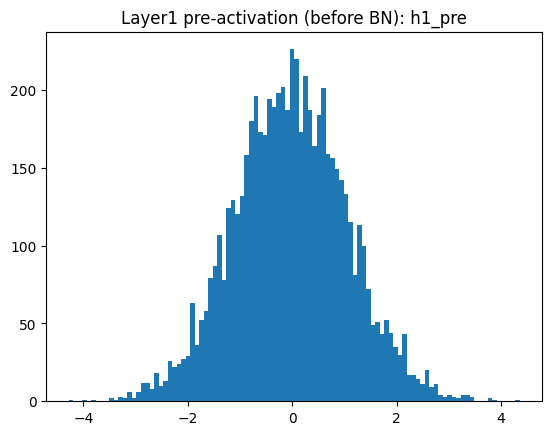

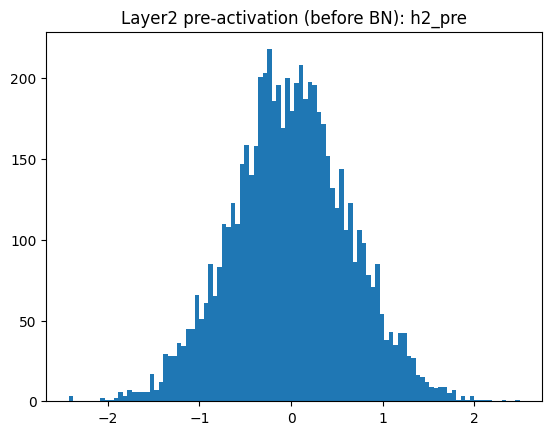

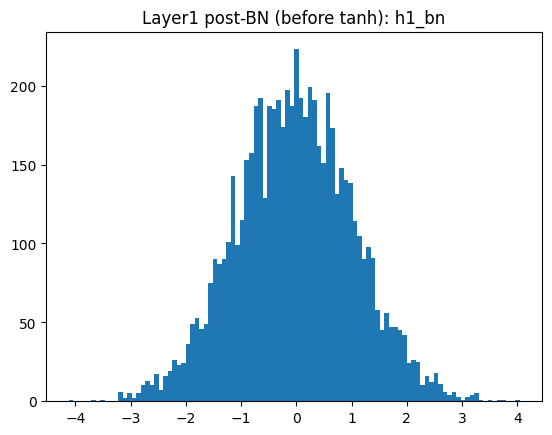

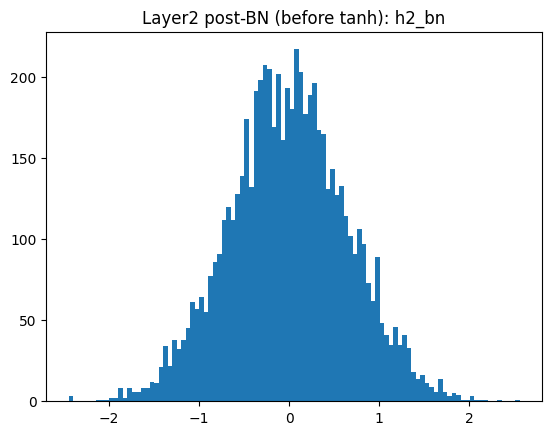

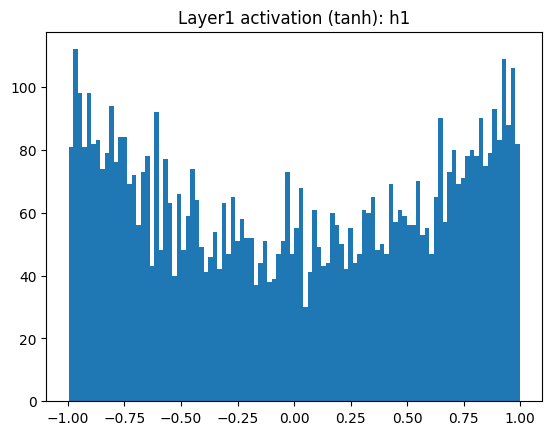

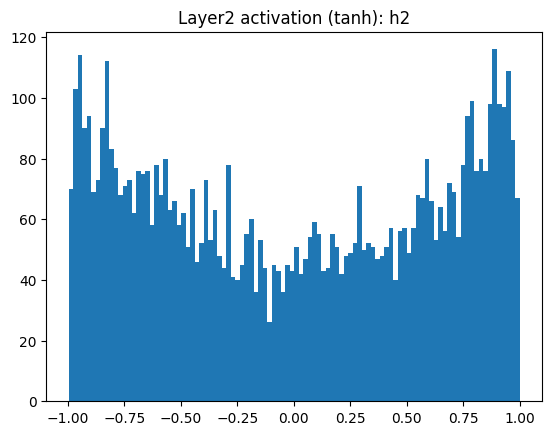

saturation h1: 0.036249998956918716
saturation h2: 0.030781248584389687


In [8]:
# activation diagnostics: histograms (pre/post BN) + saturation

# We will visualize:
# - pre-activation distributions (before BN)
# - post-BN, pre-tanh distributions (after BN)
# - tanh activations themselves (after nonlinearity)

# pre-activations
plot_hist(cache.h1_pre, "Layer1 pre-activation (before BN): h1_pre")
plot_hist(cache.h2_pre, "Layer2 pre-activation (before BN): h2_pre")

# For post-BN values, we recompute BN outputs explicitly (no extra running updates)
# (This is just for visualization convenience.)
bn1 = model.layers[3]
bn2 = model.layers[6]

with torch.no_grad():
    # temporarily avoid updating running stats while plotting by using eval-mode BN
    bn1_was_training = bn1.training
    bn2_was_training = bn2.training
    bn1.eval()
    bn2.eval()

    h1_bn = bn1(cache.h1_pre)
    h2_bn = bn2(cache.h2_pre)

    # restore training flags
    bn1.training = bn1_was_training
    bn2.training = bn2_was_training

plot_hist(h1_bn, "Layer1 post-BN (before tanh): h1_bn")
plot_hist(h2_bn, "Layer2 post-BN (before tanh): h2_bn")

# tanh activations
plot_hist(cache.h1, "Layer1 activation (tanh): h1")
plot_hist(cache.h2, "Layer2 activation (tanh): h2")

print("saturation h1:", tanh_saturation_rate(cache.h1))
print("saturation h2:", tanh_saturation_rate(cache.h2))

loss: 3.572270631790161
  param[0]  shape=      (27, 10)  grad_norm=0.115774
  param[1]  shape=     (30, 200)  grad_norm=0.746138
  param[2]  shape=        (200,)  grad_norm=0.000000
  param[3]  shape=        (200,)  grad_norm=0.059989
  param[4]  shape=        (200,)  grad_norm=0.059894
  param[5]  shape=    (200, 200)  grad_norm=1.712874
  param[6]  shape=        (200,)  grad_norm=0.000000
  param[7]  shape=        (200,)  grad_norm=0.059815
  param[8]  shape=        (200,)  grad_norm=0.180984
  param[9]  shape=     (200, 27)  grad_norm=1.510042
 param[10]  shape=         (27,)  grad_norm=0.289286


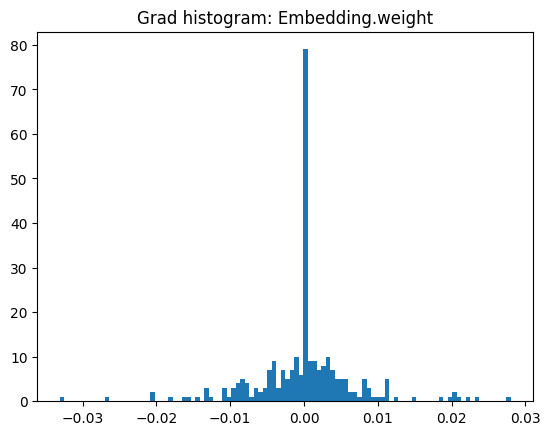

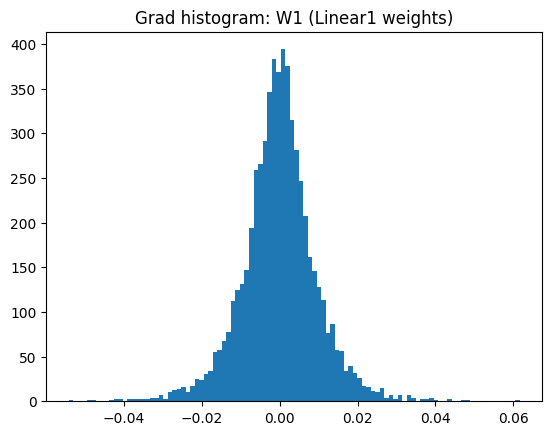

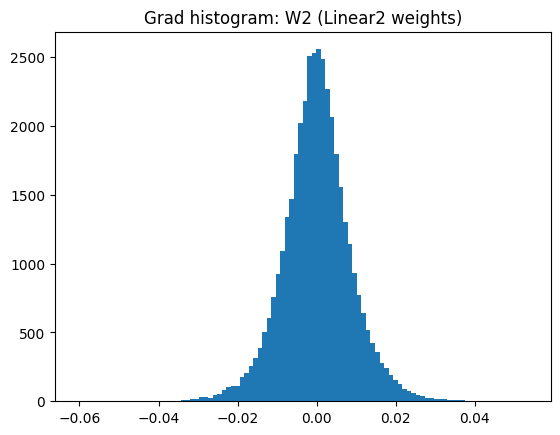

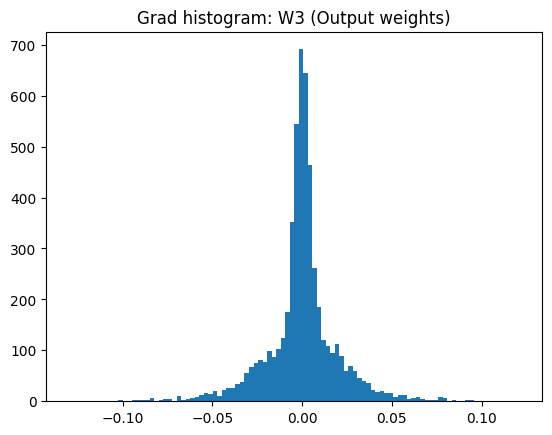

In [9]:
# one backward pass + gradient diagnostics (histograms + norms)

# clear grads
for p in params:
    p.grad = None

# forward (train mode) + loss
logits, cache = forward_with_cache(Xb, train=True)
loss = F.cross_entropy(logits, Yb)

# backward
loss.backward()

print("loss:", loss.detach().item())

# gradient norms (per parameter tensor)
for i, p in enumerate(params):
    name = f"param[{i}]"
    print(f"{name:>10}  shape={tuple(p.shape)!s:>14}  grad_norm={grad_norm(p):.6f}")

# a few informative gradient histograms:
# - embedding table gradients
plot_hist(params[0].grad, "Grad histogram: Embedding.weight")

# - first Linear weights
# (Index depends on parameter ordering; we locate by shapes to be robust.)
def find_param_by_shape(shape):
    for p in params:
        if tuple(p.shape) == shape:
            return p
    return None

W1 = find_param_by_shape((block_size * n_embed, n_hidden))
W2 = find_param_by_shape((n_hidden, n_hidden))
W3 = find_param_by_shape((n_hidden, vocab_size))

if W1 is not None: plot_hist(W1.grad, "Grad histogram: W1 (Linear1 weights)")
if W2 is not None: plot_hist(W2.grad, "Grad histogram: W2 (Linear2 weights)")
if W3 is not None: plot_hist(W3.grad, "Grad histogram: W3 (Output weights)")

In [10]:
# training loop with periodic diagnostics snapshots (short run)

def split_loss_model(X: torch.Tensor, Y: torch.Tensor, batch_size: int = 4096) -> float:
    model.eval()
    losses = []
    for start in range(0, X.shape[0], batch_size):
        xb = X[start:start+batch_size]
        yb = Y[start:start+batch_size]
        logits = model(xb)
        losses.append(F.cross_entropy(logits, yb).detach())
    return torch.stack(losses).mean().item()

def lr_at(step: int) -> float:
    return 0.1 if step < 2000 else 0.01

max_steps = 5000
batch_size = 64
eval_interval = 500

history = {
    "step": [],
    "train_loss": [],
    "dev_loss": [],
    "sat_h1": [],
    "sat_h2": [],
    "grad_W1": [],
    "grad_W2": [],
    "grad_W3": [],
}

# grab references to key weight tensors for diagnostics (stable by identity)
emb_W = model.layers[0].weight
lin1_W = model.layers[2].W
lin2_W = model.layers[5].W
lin3_W = model.layers[8].W

for step in range(max_steps + 1):
    # minibatch
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g, device=device)
    xb, yb = Xtr[ix], Ytr[ix]

    # forward (train) + loss
    model.train()
    logits, cache = forward_with_cache(xb, train=True)
    loss = F.cross_entropy(logits, yb)

    # backward
    for p in params:
        p.grad = None
    loss.backward()

    # update (SGD)
    lr = lr_at(step)
    with torch.no_grad():
        for p in params:
            p -= lr * p.grad

    # periodic evaluation + diagnostics
    if step % eval_interval == 0:
        tr = split_loss_model(Xtr, Ytr)
        dv = split_loss_model(Xdev, Ydev)

        history["step"].append(step)
        history["train_loss"].append(tr)
        history["dev_loss"].append(dv)
        history["sat_h1"].append(tanh_saturation_rate(cache.h1))
        history["sat_h2"].append(tanh_saturation_rate(cache.h2))
        history["grad_W1"].append(lin1_W.grad.detach().norm().item())
        history["grad_W2"].append(lin2_W.grad.detach().norm().item())
        history["grad_W3"].append(lin3_W.grad.detach().norm().item())

        print(f"{step:5d}/{max_steps}  lr={lr:.3g}  train={tr:.4f}  dev={dv:.4f}  sat1={history['sat_h1'][-1]:.3f}  sat2={history['sat_h2'][-1]:.3f}")

    0/5000  lr=0.1  train=3.3767  dev=3.3787  sat1=0.037  sat2=0.031
  500/5000  lr=0.1  train=2.3928  dev=2.3994  sat1=0.037  sat2=0.029
 1000/5000  lr=0.1  train=2.3468  dev=2.3523  sat1=0.036  sat2=0.033
 1500/5000  lr=0.1  train=2.3005  dev=2.3098  sat1=0.043  sat2=0.035
 2000/5000  lr=0.01  train=2.2762  dev=2.2905  sat1=0.042  sat2=0.039
 2500/5000  lr=0.01  train=2.2323  dev=2.2457  sat1=0.041  sat2=0.037
 3000/5000  lr=0.01  train=2.2275  dev=2.2411  sat1=0.041  sat2=0.039
 3500/5000  lr=0.01  train=2.2243  dev=2.2360  sat1=0.040  sat2=0.037
 4000/5000  lr=0.01  train=2.2208  dev=2.2356  sat1=0.039  sat2=0.041
 4500/5000  lr=0.01  train=2.2168  dev=2.2309  sat1=0.041  sat2=0.042
 5000/5000  lr=0.01  train=2.2141  dev=2.2283  sat1=0.043  sat2=0.042


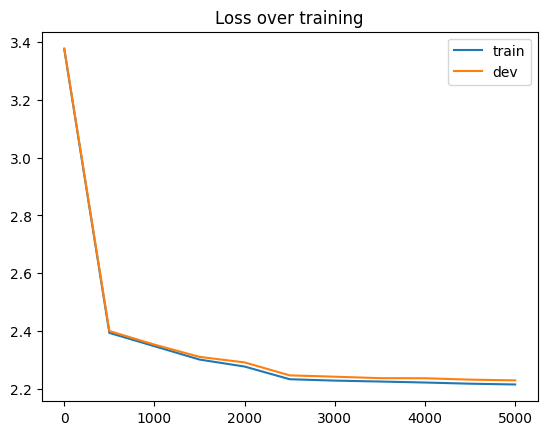

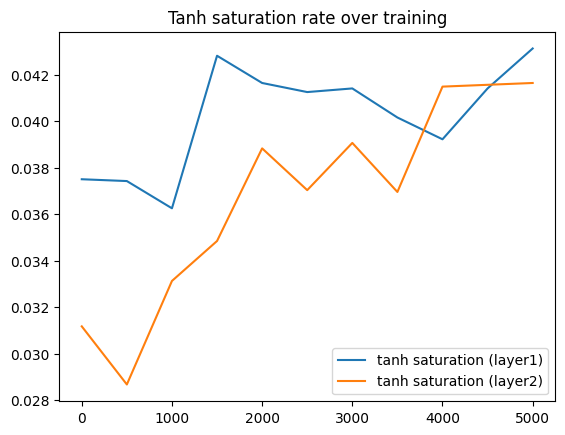

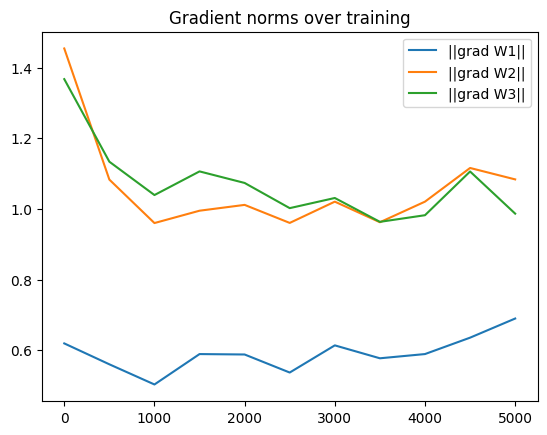

In [11]:
# plot diagnostics over time (loss, saturation, gradient norms)

# Loss curves
plt.figure()
plt.plot(history["step"], history["train_loss"], label="train")
plt.plot(history["step"], history["dev_loss"], label="dev")
plt.title("Loss over training")
plt.legend()
plt.show()

# Saturation curves
plt.figure()
plt.plot(history["step"], history["sat_h1"], label="tanh saturation (layer1)")
plt.plot(history["step"], history["sat_h2"], label="tanh saturation (layer2)")
plt.title("Tanh saturation rate over training")
plt.legend()
plt.show()

# Gradient norm curves
plt.figure()
plt.plot(history["step"], history["grad_W1"], label="||grad W1||")
plt.plot(history["step"], history["grad_W2"], label="||grad W2||")
plt.plot(history["step"], history["grad_W3"], label="||grad W3||")
plt.title("Gradient norms over training")
plt.legend()
plt.show()

In [12]:
# build a comparable model WITHOUT BatchNorm (for side-by-side comparison)

def make_model(*, use_batchnorm: bool, seed: int = SEED):
    g_local = torch.Generator(device=device).manual_seed(seed)

    layers: list[Module] = [
        Embedding(vocab_size, n_embed, generator=g_local),
        Flatten(),
        Linear(block_size * n_embed, n_hidden, generator=g_local),
    ]
    if use_batchnorm:
        layers += [BatchNorm1d(n_hidden, momentum=0.1, eps=1e-5)]
    layers += [Tanh(),
               Linear(n_hidden, n_hidden, generator=g_local)]
    if use_batchnorm:
        layers += [BatchNorm1d(n_hidden, momentum=0.1, eps=1e-5)]
    layers += [Tanh(),
               Linear(n_hidden, vocab_size, generator=g_local)]

    m = Sequential(layers)
    ps = m.parameters()
    for p in ps:
        p.requires_grad_(True)
    return m, ps

model_bn, params_bn = make_model(use_batchnorm=True, seed=SEED)
model_nobn, params_nobn = make_model(use_batchnorm=False, seed=SEED)

print("BN model params:", sum(p.nelement() for p in params_bn))
print("NoBN model params:", sum(p.nelement() for p in params_nobn))

BN model params: 52897
NoBN model params: 52097


In [13]:
# train+diagnose function (works for BN or NoBN), then run BN vs NoBN comparison

def forward_with_cache_generic(m: Sequential, Xb: torch.Tensor, *, train: bool):
    """
    Forward pass with caching for our fixed architecture:
    Embedding -> Flatten -> Linear -> (BN) -> Tanh -> Linear -> (BN) -> Tanh -> Linear
    """
    if train:
        m.train()
    else:
        m.eval()

    layers = m.layers
    # indices depend on whether BN exists; handle both cleanly
    # We'll walk and capture by type.
    cache = {}

    x = Xb
    cache["x"] = x

    x = layers[0](x); cache["emb"] = x
    x = layers[1](x); cache["flat"] = x

    x = layers[2](x); cache["h1_pre"] = x
    idx = 3
    if isinstance(layers[idx], BatchNorm1d):
        x = layers[idx](x); cache["h1_bn"] = x
        idx += 1
    x = layers[idx](x); cache["h1"] = x
    idx += 1

    x = layers[idx](x); cache["h2_pre"] = x
    idx += 1
    if idx < len(layers) and isinstance(layers[idx], BatchNorm1d):
        x = layers[idx](x); cache["h2_bn"] = x
        idx += 1
    x = layers[idx](x); cache["h2"] = x
    idx += 1

    x = layers[idx](x); cache["logits"] = x
    return x, cache


def train_with_diagnostics(m: Sequential, ps: list[torch.Tensor], *, steps: int = 3000, batch_size: int = 64, eval_interval: int = 500):
    g_local = torch.Generator(device=device).manual_seed(SEED)

    # identify key weight tensors by layer index (stable for this architecture)
    emb_W = m.layers[0].weight
    lin1_W = m.layers[2].W
    # lin2 is after first tanh (+ optional BN)
    # find the second Linear by scanning
    linear_layers = [layer for layer in m.layers if isinstance(layer, Linear)]
    lin2_W = linear_layers[1].W
    lin3_W = linear_layers[2].W

    hist = {"step": [], "train": [], "dev": [], "sat1": [], "sat2": [], "gW1": [], "gW2": [], "gW3": []}

    def split_loss_for(mdl: Sequential, X: torch.Tensor, Y: torch.Tensor) -> float:
        mdl.eval()
        losses = []
        for start in range(0, X.shape[0], 4096):
            xb = X[start:start+4096]
            yb = Y[start:start+4096]
            logits = mdl(xb)
            losses.append(F.cross_entropy(logits, yb).detach())
        return torch.stack(losses).mean().item()

    for step in range(steps + 1):
        ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g_local, device=device)
        xb, yb = Xtr[ix], Ytr[ix]

        logits, cache = forward_with_cache_generic(m, xb, train=True)
        loss = F.cross_entropy(logits, yb)

        for p in ps:
            p.grad = None
        loss.backward()

        lr = 0.1 if step < steps * 0.4 else 0.01
        with torch.no_grad():
            for p in ps:
                p -= lr * p.grad

        if step % eval_interval == 0:
            tr = split_loss_for(m, Xtr, Ytr)
            dv = split_loss_for(m, Xdev, Ydev)
            sat1 = tanh_saturation_rate(cache["h1"])
            sat2 = tanh_saturation_rate(cache["h2"])
            hist["step"].append(step)
            hist["train"].append(tr)
            hist["dev"].append(dv)
            hist["sat1"].append(sat1)
            hist["sat2"].append(sat2)
            hist["gW1"].append(lin1_W.grad.detach().norm().item())
            hist["gW2"].append(lin2_W.grad.detach().norm().item())
            hist["gW3"].append(lin3_W.grad.detach().norm().item())
            print(f"{step:4d}/{steps}  lr={lr:.3g}  train={tr:.4f}  dev={dv:.4f}  sat1={sat1:.3f} sat2={sat2:.3f}")

    return hist


print("Training BN model...")
hist_bn = train_with_diagnostics(model_bn, params_bn, steps=3000, batch_size=64, eval_interval=500)

print("\nTraining NoBN model...")
hist_nobn = train_with_diagnostics(model_nobn, params_nobn, steps=3000, batch_size=64, eval_interval=500)

Training BN model...
   0/3000  lr=0.1  train=3.3752  dev=3.3759  sat1=0.038 sat2=0.034
 500/3000  lr=0.1  train=2.4050  dev=2.4131  sat1=0.039 sat2=0.031
1000/3000  lr=0.1  train=2.3301  dev=2.3363  sat1=0.038 sat2=0.034
1500/3000  lr=0.01  train=2.2766  dev=2.2866  sat1=0.046 sat2=0.040
2000/3000  lr=0.01  train=2.2680  dev=2.2785  sat1=0.040 sat2=0.034
2500/3000  lr=0.01  train=2.2621  dev=2.2725  sat1=0.037 sat2=0.036
3000/3000  lr=0.01  train=2.2564  dev=2.2673  sat1=0.040 sat2=0.035

Training NoBN model...
   0/3000  lr=0.1  train=3.3401  dev=3.3423  sat1=0.056 sat2=0.002
 500/3000  lr=0.1  train=2.4243  dev=2.4304  sat1=0.058 sat2=0.006
1000/3000  lr=0.1  train=2.3471  dev=2.3488  sat1=0.073 sat2=0.014
1500/3000  lr=0.01  train=2.2985  dev=2.3059  sat1=0.079 sat2=0.022
2000/3000  lr=0.01  train=2.2903  dev=2.2976  sat1=0.074 sat2=0.020
2500/3000  lr=0.01  train=2.2846  dev=2.2916  sat1=0.077 sat2=0.020
3000/3000  lr=0.01  train=2.2786  dev=2.2856  sat1=0.084 sat2=0.023


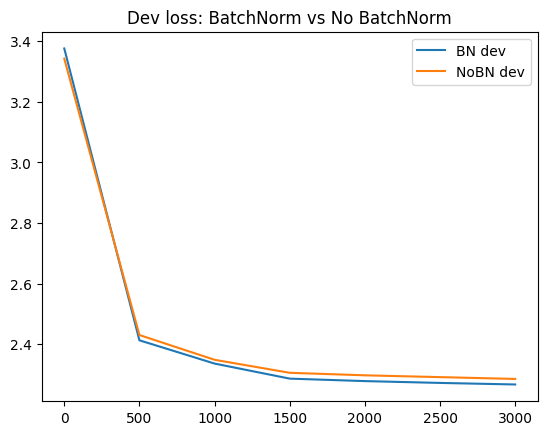

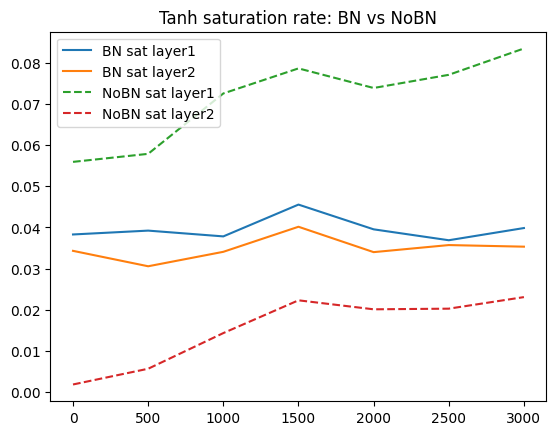

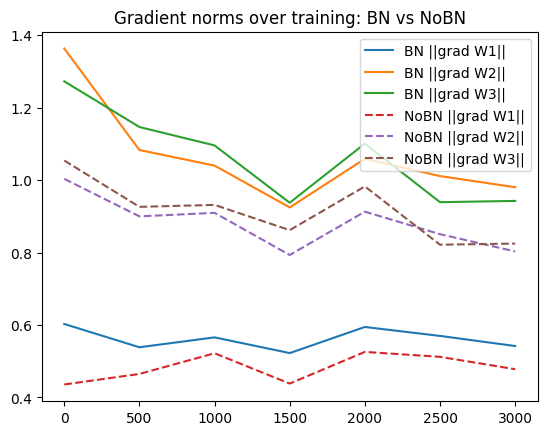

In [14]:
# compare BN vs NoBN diagnostics (loss, saturation, gradient norms)

# Loss
plt.figure()
plt.plot(hist_bn["step"], hist_bn["dev"], label="BN dev")
plt.plot(hist_nobn["step"], hist_nobn["dev"], label="NoBN dev")
plt.title("Dev loss: BatchNorm vs No BatchNorm")
plt.legend()
plt.show()

# Saturation
plt.figure()
plt.plot(hist_bn["step"], hist_bn["sat1"], label="BN sat layer1")
plt.plot(hist_bn["step"], hist_bn["sat2"], label="BN sat layer2")
plt.plot(hist_nobn["step"], hist_nobn["sat1"], "--", label="NoBN sat layer1")
plt.plot(hist_nobn["step"], hist_nobn["sat2"], "--", label="NoBN sat layer2")
plt.title("Tanh saturation rate: BN vs NoBN")
plt.legend()
plt.show()

# Gradient norms
plt.figure()
plt.plot(hist_bn["step"], hist_bn["gW1"], label="BN ||grad W1||")
plt.plot(hist_bn["step"], hist_bn["gW2"], label="BN ||grad W2||")
plt.plot(hist_bn["step"], hist_bn["gW3"], label="BN ||grad W3||")
plt.plot(hist_nobn["step"], hist_nobn["gW1"], "--", label="NoBN ||grad W1||")
plt.plot(hist_nobn["step"], hist_nobn["gW2"], "--", label="NoBN ||grad W2||")
plt.plot(hist_nobn["step"], hist_nobn["gW3"], "--", label="NoBN ||grad W3||")
plt.title("Gradient norms over training: BN vs NoBN")
plt.legend()
plt.show()

In [15]:
# PyTorch reference model (nn.Linear + nn.BatchNorm1d) and sanity comparison

import torch.nn as nn

class TorchMLP(nn.Module):
    """
    PyTorch reference implementation for Part 3.
    This mirrors our custom architecture as closely as possible.
    """
    def __init__(self, vocab_size: int, block_size: int, n_embed: int, n_hidden: int):
        super().__init__()
        self.embed = nn.Embedding(vocab_size, n_embed)
        self.fc1 = nn.Linear(block_size * n_embed, n_hidden, bias=True)
        self.bn1 = nn.BatchNorm1d(n_hidden, momentum=0.1, eps=1e-5, affine=True)
        self.fc2 = nn.Linear(n_hidden, n_hidden, bias=True)
        self.bn2 = nn.BatchNorm1d(n_hidden, momentum=0.1, eps=1e-5, affine=True)
        self.fc3 = nn.Linear(n_hidden, vocab_size, bias=True)

    def forward(self, x):
        # x: (B, T)
        x = self.embed(x)                  # (B, T, n_embed)
        x = x.view(x.shape[0], -1)         # (B, T*n_embed)
        x = torch.tanh(self.bn1(self.fc1(x)))
        x = torch.tanh(self.bn2(self.fc2(x)))
        x = self.fc3(x)
        return x


# instantiate and move to device
torch_model = TorchMLP(vocab_size, block_size, n_embed, n_hidden).to(device)

# quick forward sanity check
torch_model.train()
logits_torch = torch_model(Xb)
loss_torch = F.cross_entropy(logits_torch, Yb)

print("torch logits:", logits_torch.shape)
print("torch loss:", loss_torch.detach().item())

# compare to our custom BN model (not numerically equal, but behaviorally similar)
model_bn.train()
logits_custom = model_bn(Xb)
loss_custom = F.cross_entropy(logits_custom, Yb)

print("custom loss:", loss_custom.detach().item())

torch logits: torch.Size([32, 27])
torch loss: 3.2586936950683594
custom loss: 2.3483963012695312
